In [1]:
!pip install --upgrade eli5
!pip install better_profanity
!pip install shap

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
import spacy
import nltk

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn import set_config
from better_profanity import profanity
from wordcloud import WordCloud
from nltk.corpus import stopwords
from textblob import TextBlob

nltk.download('stopwords')
nlp = spacy.load('en_core_web_sm')
stop = stopwords.words('english')
set_config(display="diagram")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bhari\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_csv("train-balanced-sarcasm.csv")
print("Number of Rows: {}\nNumber of Columns: {}".format(df.shape[0],df.shape[1]))
df.head()

Number of Rows: 1010826
Number of Columns: 10


,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


# Handling Missing Values

In [4]:
total_nan_rows = df.isna().sum(axis=1).sum()
print("Total number of rows with NaN values:", total_nan_rows)

Total number of rows with NaN values: 55


In [5]:
df = df.dropna(axis=0)
total_nan_rows = df.isna().sum(axis=1).sum()
print("Total number of rows with NaN values:", total_nan_rows)

Total number of rows with NaN values: 0


In [6]:
print("Number of Rows: {}\nNumber of Columns: {}".format(df.shape[0],df.shape[1]))

Number of Rows: 1010771
Number of Columns: 10


# EDA(Exploratory Data Analysis)

In [7]:
df.columns

Index(['label', 'comment', 'author', 'subreddit', 'score', 'ups', 'downs',
       'date', 'created_utc', 'parent_comment'],
      dtype='object')

In [8]:
df.describe()

,label,score,ups,downs
count,1.010771e+06,1.010771e+06,1.010771e+06,1.010771e+06
mean,4.999827e-01,6.886007e+00,5.499149e+00,-1.458679e-01
std,5.000002e-01,4.834416e+01,4.127406e+01,3.529739e-01
min,0.000000e+00,-5.070000e+02,-5.070000e+02,-1.000000e+00
25%,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,2.000000e+00,1.000000e+00,0.000000e+00
75%,1.000000e+00,4.000000e+00,3.000000e+00,0.000000e+00
max,1.000000e+00,9.070000e+03,5.163000e+03,0.000000e+00


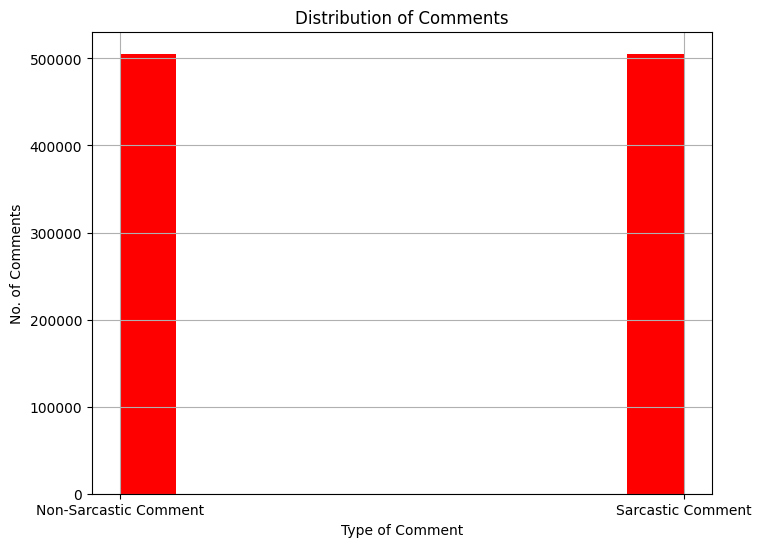

In [9]:
plt.figure(figsize=(8, 6))
df['label'].hist(color='red')
plt.title('Distribution of Comments')
plt.xlabel('Type of Comment')
plt.ylabel('No. of Comments')
plt.xticks([1,0],['Sarcastic Comment', 'Non-Sarcastic Comment'])
plt.show()

In [10]:
no_of_sarcasm = df.loc[df['label']==1].shape[0]
no_of_non_sarcasm = df.loc[df['label']==0].shape[0]

print("No. of Sarcastic Comments: {}\nNo. of Non-Sarcastic Comments: {}".format(no_of_sarcasm,no_of_non_sarcasm))

No. of Sarcastic Comments: 505368
No. of Non-Sarcastic Comments: 505403


In [11]:
# Finding Correlation of numerical values in the dataset

df_corr = df[['score','ups','downs']]
df_corr.corr()

,score,ups,downs
score,1.000000,0.849238,-0.013862
ups,0.849238,1.000000,0.065072
downs,-0.013862,0.065072,1.000000


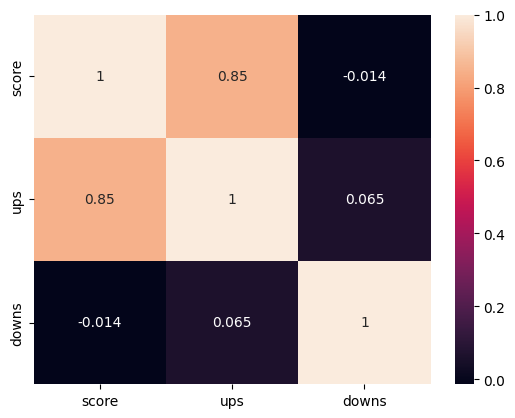

In [12]:
corrmap = sns.heatmap(df_corr.corr(), annot=True) 
plt.show()

In [13]:
# Finding Correlation of numerical values in the dataset

df_corr = df[['score','ups','downs','label']]
df_corr.corr()

,score,ups,downs,label
score,1.000000,0.849238,-0.013862,-0.010024
ups,0.849238,1.000000,0.065072,-0.006693
downs,-0.013862,0.065072,1.000000,0.057532
label,-0.010024,-0.006693,0.057532,1.000000


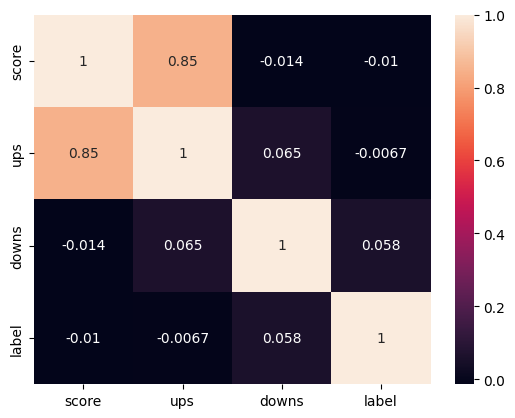

In [14]:
corrmap = sns.heatmap(df_corr.corr(), annot=True) 
plt.show()

In [15]:
df_sarcasm = df.loc[df['label']==1]
df_non_sarcasm = df.loc[df['label']==0]

In [16]:
nlp.max_length = 3000000  #Override the default allowed max length for a doc object

df_sarcasm = df_sarcasm.sample(50000,replace=False,random_state=1)
df_sarcasm['comment'] = df_sarcasm['comment'].astype(str).apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_sarcasm_text = df_sarcasm['comment'].tolist()
df_sarcasm_text = " ".join(df_sarcasm_text)
sarcasm_doc = nlp(df_sarcasm_text)

df_non_sarcasm  = df_non_sarcasm.sample(50000,replace=False,random_state=1)
df_non_sarcasm['comment'] = df_non_sarcasm['comment'].astype(str).apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_non_sarcasm_text = df_non_sarcasm['comment'].tolist()
df_non_sarcasm_text = " ".join(df_non_sarcasm_text)
non_sarcasm_doc = nlp(df_non_sarcasm_text)

In [17]:
average_word_length_sarcasm = sum(len(word) for word in sarcasm_doc) / len(sarcasm_doc)
average_word_length_non_sarcasm = sum(len(word) for word in non_sarcasm_doc) / len(non_sarcasm_doc)

In [18]:
print(f"Average word length of sarcastic comments: {average_word_length_sarcasm}")
print(f"Average word length of non sarcastic comments: {average_word_length_non_sarcasm}")

Average word length of sarcastic comments: 4.384103255422363
Average word length of non sarcastic comments: 4.2674973616041445


In [19]:
average_sentence_length_sarcasm = len(df_sarcasm['comment'].sum()) / len(df_sarcasm)
average_sentence_length_non_sarcasm = len(df_non_sarcasm['comment'].sum()) / len(df_non_sarcasm)

In [20]:
print(f"The average sentence length for sarcastic comments is: {average_sentence_length_sarcasm}")
print(f"The average sentence length for non sarcastic comments is: {average_sentence_length_non_sarcasm}")

The average sentence length for sarcastic comments is: 40.34772
The average sentence length for non sarcastic comments is: 41.1994


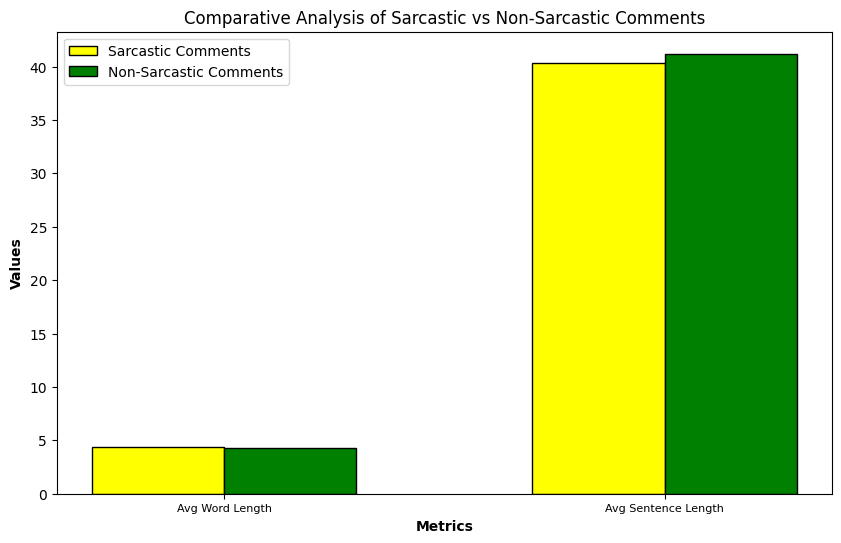

In [21]:
# Data for plotting
categories = ['Avg Word Length', 'Avg Sentence Length']
sarcasm_values = [average_word_length_sarcasm, average_sentence_length_sarcasm]
non_sarcasm_values = [average_word_length_non_sarcasm, average_sentence_length_non_sarcasm]

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 6))

# Number of bars
n_bars = len(categories)

# Positions of the left bar-boundaries
barWidth = 0.3
r1 = np.arange(n_bars)
r2 = [x + barWidth for x in r1]

# Creating the bar plot
plt.bar(r1, sarcasm_values, color='yellow', width=barWidth, edgecolor='black', label='Sarcastic Comments')
plt.bar(r2, non_sarcasm_values, color='green', width=barWidth, edgecolor='black', label='Non-Sarcastic Comments')

# Adding titles and labels
plt.xlabel('Metrics', fontweight='bold', fontsize=10)
plt.ylabel('Values', fontweight='bold', fontsize=10)
plt.xticks([r + barWidth/2 for r in range(n_bars)], categories, fontsize=8)
plt.title('Comparative Analysis of Sarcastic vs Non-Sarcastic Comments', fontsize=12)

# Create legend & Show graphic
plt.legend()
plt.show()

In [22]:
df['subreddit'].value_counts()

subreddit
AskReddit                65674
politics                 39493
worldnews                26375
leagueoflegends          21034
pcmasterrace             18987
                         ...  
LabiaGW                      1
Expected                     1
AnimalsStoppingFights        1
panderingfromtheright        1
Pandemic                     1
Name: count, Length: 14876, dtype: int64

In [23]:
def entity_wordcloud(df):
    named_entities = []
    for sent in df:
        sent = nlp(sent)
        for ent in sent.ents:
            if ent.label_ == 'PERSON' or 'ORG' or 'GPE':
                named_entities.append(ent.text)

    doc = " ".join(named_entities)

    plt.figure(figsize=(10,5))
    wordcloud = WordCloud(background_color="white",
                      max_words=45,
                      max_font_size=30,
                      random_state=42
                     ).generate(doc)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

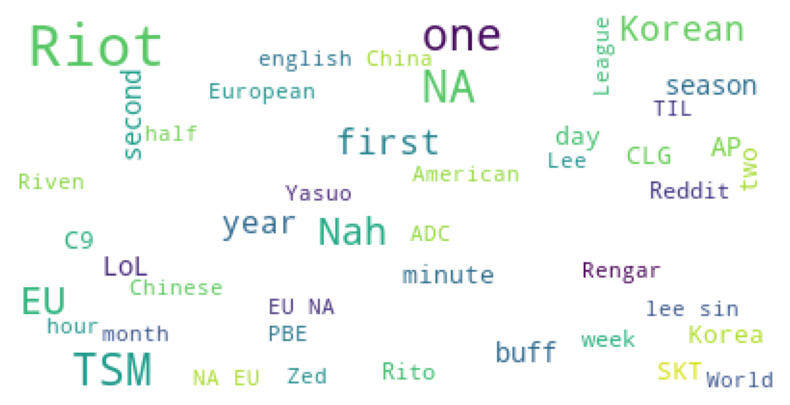

In [24]:
df_askreddit = df.loc[(df['subreddit']=='leagueoflegends') & (df['label']==1)]
entity_wordcloud(df_askreddit['comment'].astype(str))

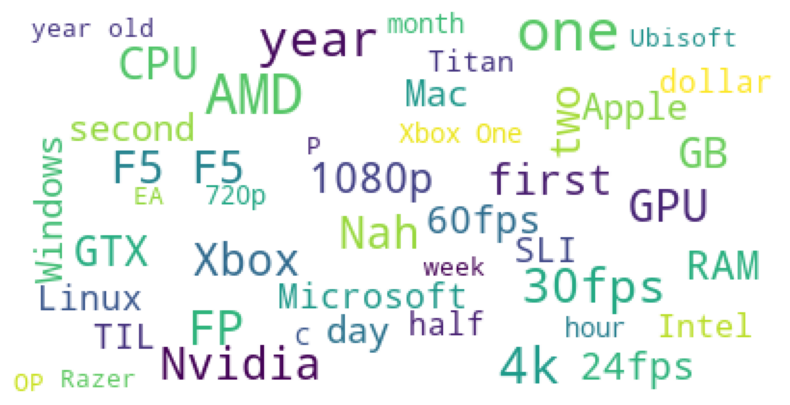

In [25]:
df_worldnews = df.loc[(df['subreddit']=='pcmasterrace') & (df['label']==1)]
entity_wordcloud(df_worldnews['comment'].astype(str))

# Building Data for Grid Search and Random Search

In [26]:
# Taking sample data of 10000 to try out different parameters and models
np.random.seed(42)
sampled_df = df.groupby('label').apply(lambda x: x.sample(n=5000,replace=False,random_state=1)).reset_index(drop = True)

C:\Users\bhari\AppData\Local\Temp\ipykernel_17768\1766556750.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('label').apply(lambda x: x.sample(n=5000,replace=False,random_state=1)).reset_index(drop = True)


In [27]:
# Creating testing, training and validation sets
from sklearn.feature_extraction.text import TfidfVectorizer

X_dummy,X_test,Y_dummy,Y_test = train_test_split(sampled_df['comment'].astype(str),sampled_df['label'],test_size=0.2,shuffle=True,stratify=sampled_df['label'],random_state=42)
X_train,X_val,Y_train,Y_val = train_test_split(X_dummy,Y_dummy,test_size=0.2,shuffle=True,stratify=Y_dummy,random_state=42)

# Random Search on SVC

In [28]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV

lisvc_param_grid = {
    'tfidf__ngram_range': [(1,1),(1,2)],
    'clf__C': [0.001,0.01,0.1,1.0,10,100,1000],
    'clf__kernel': ['linear']
}

lisvc_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', SVC(max_iter=2500,random_state=42))
])

lisvc_gs = RandomizedSearchCV(lisvc_pipeline,
                      param_distributions=lisvc_param_grid,
                      random_state=42,
                      cv=2, n_jobs=-1,
                      scoring='accuracy')
lisvc_gs.fit(X_train, Y_train)
print(lisvc_gs.best_estimator_)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('clf',
                 SVC(C=10, kernel='linear', max_iter=2500, random_state=42))])


C:\Users\bhari\anaconda3\envs\ProjectML\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=2500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [29]:
print(f"The accuracy on the validation set is: {lisvc_gs.score(X_val,Y_val)}")
print(f"The accuracy on the test set is:  {lisvc_gs.score(X_test,Y_test)}")

The accuracy on the validation set is: 0.643125
The accuracy on the test set is:  0.605


In [30]:
lisvc_results = lisvc_gs.cv_results_
lisvc_results_df = pd.DataFrame(lisvc_results)
livsc_final_result = lisvc_results_df[['rank_test_score','params','mean_test_score']].sort_values(by=['rank_test_score'])
livsc_final_result = livsc_final_result.reset_index()
livsc_final_result = livsc_final_result.drop(columns=['index'])

print("Below is the ranking of models generated using random search")
for ind in livsc_final_result.index:
    print("Model {}:\nRank: {}\nParameters: {}\nTest Score:{}\n".format(ind+1,livsc_final_result['rank_test_score'][ind], livsc_final_result['params'][ind], livsc_final_result['mean_test_score'][ind]))

Below is the ranking of models generated using random search
Model 1:
Rank: 1
Parameters: {'tfidf__ngram_range': (1, 2), 'clf__kernel': 'linear', 'clf__C': 10}
Test Score:0.6115625

Model 2:
Rank: 2
Parameters: {'tfidf__ngram_range': (1, 1), 'clf__kernel': 'linear', 'clf__C': 0.001}
Test Score:0.6025

Model 3:
Rank: 2
Parameters: {'tfidf__ngram_range': (1, 1), 'clf__kernel': 'linear', 'clf__C': 0.01}
Test Score:0.6025

Model 4:
Rank: 4
Parameters: {'tfidf__ngram_range': (1, 2), 'clf__kernel': 'linear', 'clf__C': 1000}
Test Score:0.6003125

Model 5:
Rank: 5
Parameters: {'tfidf__ngram_range': (1, 2), 'clf__kernel': 'linear', 'clf__C': 100}
Test Score:0.59984375

Model 6:
Rank: 6
Parameters: {'tfidf__ngram_range': (1, 1), 'clf__kernel': 'linear', 'clf__C': 10}
Test Score:0.5946875

Model 7:
Rank: 7
Parameters: {'tfidf__ngram_range': (1, 1), 'clf__kernel': 'linear', 'clf__C': 0.1}
Test Score:0.58984375

Model 8:
Rank: 8
Parameters: {'tfidf__ngram_range': (1, 1), 'clf__kernel': 'linear', 'c

In [31]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV

rbfsvc_param_grid = {
    'tfidf__ngram_range': [(1,1),(1,2)],
    'clf__C': [0.001,0.01,0.1,1.0,10,100,1000],
    'clf__kernel': ['rbf'],
    'clf__gamma' : [0.001,0.01,0.1,1.0,10,100,1000]
}

rbfsvc_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', SVC(random_state=42))
])

rbfsvc_gs = RandomizedSearchCV(rbfsvc_pipeline,
                      param_distributions=rbfsvc_param_grid,
                      random_state=42,
                      cv=2, n_jobs=-1,
                      scoring='accuracy')
rbfsvc_gs.fit(X_train, Y_train)
print(rbfsvc_gs.best_estimator_)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', SVC(C=10, gamma=1.0, random_state=42))])


In [32]:
print(f"The accuracy on the validation set is: {rbfsvc_gs.score(X_val,Y_val)}")
print(f"The accuracy on the test set is:  {rbfsvc_gs.score(X_test,Y_test)}")

The accuracy on the validation set is: 0.65375
The accuracy on the test set is:  0.617


In [33]:
rbfsvc_results = rbfsvc_gs.cv_results_
rbfsvc_results_df = pd.DataFrame(rbfsvc_results)
rbfvsc_final_result = rbfsvc_results_df[['rank_test_score','params','mean_test_score']].sort_values(by=['rank_test_score'])
rbfvsc_final_result = rbfvsc_final_result.reset_index()
rbfvsc_final_result = rbfvsc_final_result.drop(columns=['index'])

print("Below is the ranking of models generated using random search")
for ind in rbfvsc_final_result.index:
    print("Model {}:\nRank: {}\nParameters: {}\nTest Score:{}\n".format(ind+1,rbfvsc_final_result['rank_test_score'][ind], rbfvsc_final_result['params'][ind], rbfvsc_final_result['mean_test_score'][ind]))

Below is the ranking of models generated using random search
Model 1:
Rank: 1
Parameters: {'tfidf__ngram_range': (1, 1), 'clf__kernel': 'rbf', 'clf__gamma': 1.0, 'clf__C': 10}
Test Score:0.6192187499999999

Model 2:
Rank: 2
Parameters: {'tfidf__ngram_range': (1, 1), 'clf__kernel': 'rbf', 'clf__gamma': 0.001, 'clf__C': 1.0}
Test Score:0.60265625

Model 3:
Rank: 2
Parameters: {'tfidf__ngram_range': (1, 1), 'clf__kernel': 'rbf', 'clf__gamma': 0.001, 'clf__C': 0.001}
Test Score:0.60265625

Model 4:
Rank: 4
Parameters: {'tfidf__ngram_range': (1, 1), 'clf__kernel': 'rbf', 'clf__gamma': 0.1, 'clf__C': 0.01}
Test Score:0.5984375

Model 5:
Rank: 5
Parameters: {'tfidf__ngram_range': (1, 1), 'clf__kernel': 'rbf', 'clf__gamma': 10, 'clf__C': 10}
Test Score:0.5259375

Model 6:
Rank: 6
Parameters: {'tfidf__ngram_range': (1, 1), 'clf__kernel': 'rbf', 'clf__gamma': 100, 'clf__C': 1000}
Test Score:0.51875

Model 7:
Rank: 6
Parameters: {'tfidf__ngram_range': (1, 2), 'clf__kernel': 'rbf', 'clf__gamma': 1

# Grid Search on Logistic Regression

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

lr_param_grid = { 
    'tfidf__ngram_range': [(1,2)],
    'clf__C': [0.001,0.01,0.1,1.0,10,100,1000],
    'clf__solver': ['lbfgs','saga',],
    'clf__penalty': ['l2'],
}

lr_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=42))
])

lr_gs = GridSearchCV(lr_pipeline,
                      param_grid=lr_param_grid,
                      cv=2, n_jobs=-1,
                      scoring='accuracy')
lr_gs.fit(X_train, Y_train)
print(lr_gs.best_estimator_)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('clf', LogisticRegression(C=100, random_state=42))])


In [35]:
print(f"The accuracy on the validation set is: {lr_gs.score(X_val,Y_val)}")
print(f"The accuracy on the test set is:  {lr_gs.score(X_test,Y_test)}")

The accuracy on the validation set is: 0.655625
The accuracy on the test set is:  0.6095


In [36]:
lr_results = lr_gs.cv_results_
lr_results_df = pd.DataFrame(lr_results)
lr_final_result = lr_results_df[['rank_test_score','params','mean_test_score']].sort_values(by=['rank_test_score'])
lr_final_result = lr_final_result.reset_index()
lr_final_result = lr_final_result.drop(columns=['index'])

print("Below is the ranking of models generated using grid search")
for ind in lr_final_result.index:
    print("Model {}:\nRank: {}\nParameters: {}\nTest Score:{}\n".format(ind+1,lr_final_result['rank_test_score'][ind], lr_final_result['params'][ind], lr_final_result['mean_test_score'][ind]))

Below is the ranking of models generated using grid search
Model 1:
Rank: 1
Parameters: {'clf__C': 100, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs', 'tfidf__ngram_range': (1, 2)}
Test Score:0.62375

Model 2:
Rank: 2
Parameters: {'clf__C': 1.0, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs', 'tfidf__ngram_range': (1, 2)}
Test Score:0.6214062499999999

Model 3:
Rank: 3
Parameters: {'clf__C': 1.0, 'clf__penalty': 'l2', 'clf__solver': 'saga', 'tfidf__ngram_range': (1, 2)}
Test Score:0.620625

Model 4:
Rank: 4
Parameters: {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs', 'tfidf__ngram_range': (1, 2)}
Test Score:0.62046875

Model 5:
Rank: 5
Parameters: {'clf__C': 1000, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs', 'tfidf__ngram_range': (1, 2)}
Test Score:0.62015625

Model 6:
Rank: 6
Parameters: {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'saga', 'tfidf__ngram_range': (1, 2)}
Test Score:0.6200000000000001

Model 7:
Rank: 7
Parameters: {'clf__C': 0.1, 'clf__penalty': 'l2', 'c

# Grid Search on Decision Tree

In [37]:
from sklearn.tree  import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

dt_param_grid = {
    'tfidf__ngram_range': [(1,1),(1,2)],
    'clf__splitter': ['best','random'],
    'clf__max_depth': [1, 3, 5, 10, 15, 20],
    'clf__criterion': ['gini','entropy','log_loss']
}

df_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', DecisionTreeClassifier(random_state=42))
])

df_gs = GridSearchCV(df_pipeline,
                      param_grid=dt_param_grid,
                      cv=2, n_jobs=-1,
                      scoring='accuracy')
df_gs.fit(X_train, Y_train)
print(df_gs.best_estimator_)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf',
                 DecisionTreeClassifier(max_depth=20, random_state=42,
                                        splitter='random'))])


In [38]:
print(f"The accuracy on the validation set is: {df_gs.score(X_val,Y_val)}")
print(f"The accuracy on the test set is:  {df_gs.score(X_test,Y_test)}")

The accuracy on the validation set is: 0.575625
The accuracy on the test set is:  0.563


In [39]:
dt_results = df_gs.cv_results_
dt_results_df = pd.DataFrame(dt_results)
dt_final_result = dt_results_df[['rank_test_score','params','mean_test_score']].sort_values(by=['rank_test_score'])
dt_final_result = dt_final_result.reset_index()
dt_final_result = dt_final_result.drop(columns=['index'])

print("Below is the ranking of models generated using grid search")
for ind in dt_final_result.index:
    print("Model {}:\nRank: {}\nParameters: {}\nTest Score:{}\n".format(ind+1,dt_final_result['rank_test_score'][ind], dt_final_result['params'][ind], dt_final_result['mean_test_score'][ind]))

Below is the ranking of models generated using grid search
Model 1:
Rank: 1
Parameters: {'clf__criterion': 'gini', 'clf__max_depth': 20, 'clf__splitter': 'random', 'tfidf__ngram_range': (1, 1)}
Test Score:0.5943750000000001

Model 2:
Rank: 2
Parameters: {'clf__criterion': 'gini', 'clf__max_depth': 20, 'clf__splitter': 'best', 'tfidf__ngram_range': (1, 1)}
Test Score:0.5890625

Model 3:
Rank: 3
Parameters: {'clf__criterion': 'gini', 'clf__max_depth': 15, 'clf__splitter': 'random', 'tfidf__ngram_range': (1, 1)}
Test Score:0.5860937500000001

Model 4:
Rank: 4
Parameters: {'clf__criterion': 'gini', 'clf__max_depth': 15, 'clf__splitter': 'best', 'tfidf__ngram_range': (1, 1)}
Test Score:0.5859375

Model 5:
Rank: 5
Parameters: {'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__splitter': 'best', 'tfidf__ngram_range': (1, 1)}
Test Score:0.58203125

Model 6:
Rank: 6
Parameters: {'clf__criterion': 'gini', 'clf__max_depth': 20, 'clf__splitter': 'random', 'tfidf__ngram_range': (1, 2)}
Test Sco

# Building of SVC, Logistic Regression and Decision Tree

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

train_df = df.groupby('label').apply(lambda x: x.sample(n=50000,replace=False,random_state=1)).reset_index(drop = True)

svc = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', SVC(C=10,gamma=1.0,kernel='rbf',max_iter=2500,random_state=42))
])

lr = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))),
    ('clf', LogisticRegression(C=1.0,penalty='l2',solver='saga',n_jobs=-1,random_state=42))
])

dt = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))),
    ('clf', DecisionTreeClassifier(criterion='entropy',splitter='random',max_depth=15,random_state=42))
])

X_dummy,X_test,Y_dummy,Y_test = train_test_split(train_df['comment'].astype(str),train_df['label'],test_size=0.2,shuffle=True,stratify=train_df['label'],random_state=42)
X_train,X_val,Y_train,Y_val = train_test_split(X_dummy,Y_dummy,test_size=0.2,shuffle=True,stratify=Y_dummy,random_state=42)

C:\Users\bhari\AppData\Local\Temp\ipykernel_17768\351741948.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df = df.groupby('label').apply(lambda x: x.sample(n=50000,replace=False,random_state=1)).reset_index(drop = True)


In [41]:
svc.fit(X_train, Y_train)

C:\Users\bhari\anaconda3\envs\ProjectML\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=2500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', SVC(C=10, gamma=1.0, max_iter=2500, random_state=42))])

In [42]:
lr.fit(X_train, Y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('clf',
                 LogisticRegression(n_jobs=-1, random_state=42,
                                    solver='saga'))])

In [43]:
dt.fit(X_train, Y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('clf',
                 DecisionTreeClassifier(criterion='entropy', max_depth=15,
                                        random_state=42, splitter='random'))])

# SVC Performance Metric

In [44]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.metrics import classification_report

# Make predictions
svc_y_pred_prob = svc.predict(X_test)
svc_y_pred = [1 if prob > 0.5 else 0 for prob in svc_y_pred_prob]  # Convert probabilities to class labels

# Calculate metrics
svc_accuracy = accuracy_score(Y_test, svc_y_pred)
svc_precision = precision_score(Y_test, svc_y_pred)
svc_recall = recall_score(Y_test, svc_y_pred)
svc_roc_auc = roc_auc_score(Y_test, svc_y_pred)
svc_f1 = f1_score(Y_test, svc_y_pred)

# Print the metrics
print(f"Accuracy: {svc_accuracy:.2f}")
print(f"Precision: {svc_precision:.2f}")
print(f"Recall: {svc_recall:.2f}")
print(f"ROC AUC: {svc_roc_auc:.2f}")
print(f"F1 Score: {svc_f1:.2f}")

# Alternatively, print a classification report
print("\nClassification Report:")
print(classification_report(Y_test, svc_y_pred))

Accuracy: 0.59
Precision: 0.62
Recall: 0.47
ROC AUC: 0.59
F1 Score: 0.54

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.72      0.64     10000
           1       0.62      0.47      0.54     10000

    accuracy                           0.59     20000
   macro avg       0.60      0.59      0.59     20000
weighted avg       0.60      0.59      0.59     20000



In [45]:
svc_model = svc.named_steps['clf']
print("SVC\nWeights: {}\nBias: {}".format(svc_model.dual_coef_,svc_model.intercept_))

SVC
Weights:   (0, 0)	-2.1845094042196296
  (0, 1)	-1.5362375781829234
  (0, 2)	-1.5455314609880668
  (0, 3)	-1.4940498646673648
  (0, 4)	-1.7331250375423064
  (0, 5)	-1.5518353092438795
  (0, 6)	-1.8518884971688723
  (0, 7)	-1.5408055844912532
  (0, 8)	-1.645755839667962
  (0, 9)	-3.0716124107808938
  (0, 10)	-1.4950859119926474
  (0, 11)	-1.5699403158096061
  (0, 12)	-1.5463312725310767
  (0, 13)	-1.628420236060297
  (0, 14)	-1.589198426786496
  (0, 15)	-1.7037526492050232
  (0, 16)	-1.6547526668331909
  (0, 17)	-1.9287357988868667
  (0, 18)	-2.5155621569381563
  (0, 19)	-1.5809507405852208
  (0, 20)	-2.8403006350972566
  (0, 21)	-1.567805334497042
  (0, 22)	-1.6422460209504097
  (0, 23)	-1.5972672483674235
  (0, 24)	-1.7048683611292814
  :	:
  (0, 4544)	10.0
  (0, 4545)	1.5387748635726368
  (0, 4546)	1.916146761433974
  (0, 4547)	1.67580233575406
  (0, 4548)	10.0
  (0, 4549)	1.601283234190409
  (0, 4550)	2.6894689467089004
  (0, 4551)	2.01726212008948
  (0, 4552)	2.1523780568889737


# LR Performance Metric

In [46]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.metrics import classification_report

# Make predictions
lr_y_pred_prob = lr.predict(X_test)
lr_y_pred = [1 if prob > 0.5 else 0 for prob in lr_y_pred_prob]  # Convert probabilities to class labels

# Calculate metrics
lr_accuracy = accuracy_score(Y_test, lr_y_pred)
lr_precision = precision_score(Y_test, lr_y_pred)
lr_recall = recall_score(Y_test, lr_y_pred)
lr_roc_auc = roc_auc_score(Y_test, lr_y_pred)
lr_f1 = f1_score(Y_test, lr_y_pred)

# Print the metrics
print(f"Accuracy: {lr_accuracy:.2f}")
print(f"Precision: {lr_precision:.2f}")
print(f"Recall: {lr_recall:.2f}")
print(f"ROC AUC: {lr_roc_auc:.2f}")
print(f"F1 Score: {lr_f1:.2f}")

# Alternatively, print a classification report
print("\nClassification Report:")
print(classification_report(Y_test, lr_y_pred))

Accuracy: 0.69
Precision: 0.70
Recall: 0.66
ROC AUC: 0.69
F1 Score: 0.68

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.71      0.70     10000
           1       0.70      0.66      0.68     10000

    accuracy                           0.69     20000
   macro avg       0.69      0.69      0.69     20000
weighted avg       0.69      0.69      0.69     20000



In [47]:
lr_model = lr.named_steps['clf']
print("Logistic Regression\nWeights: {}\nBias: {}".format(lr_model.coef_,lr_model.intercept_))

Logistic Regression
Weights: [[ 0.04735154  0.20536975 -0.07958932 ... -0.18530665 -0.18530665
  -0.15580991]]
Bias: [-0.33335452]


# Decision Tree Performance Metric

In [48]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.metrics import classification_report

# Make predictions
dt_y_pred_prob = dt.predict(X_test)
dt_y_pred = [1 if prob > 0.5 else 0 for prob in dt_y_pred_prob]  # Convert probabilities to class labels

# Calculate metrics
dt_accuracy = accuracy_score(Y_test, dt_y_pred)
dt_precision = precision_score(Y_test, dt_y_pred)
dt_recall = recall_score(Y_test, dt_y_pred)
dt_roc_auc = roc_auc_score(Y_test, dt_y_pred)
dt_f1 = f1_score(Y_test, dt_y_pred)

# Print the metrics
print(f"Accuracy: {dt_accuracy:.2f}")
print(f"Precision: {dt_precision:.2f}")
print(f"Recall: {dt_recall:.2f}")
print(f"ROC AUC: {dt_roc_auc:.2f}")
print(f"F1 Score: {dt_f1:.2f}")

# Alternatively, print a classification report
print("\nClassification Report:")
print(classification_report(Y_test, dt_y_pred))

Accuracy: 0.59
Precision: 0.72
Recall: 0.29
ROC AUC: 0.59
F1 Score: 0.42

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.89      0.68     10000
           1       0.72      0.29      0.42     10000

    accuracy                           0.59     20000
   macro avg       0.64      0.59      0.55     20000
weighted avg       0.64      0.59      0.55     20000



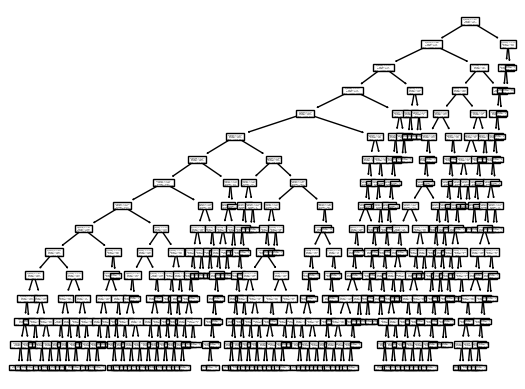

In [49]:
from sklearn import tree

dt_tree = dt.named_steps['clf']
tree.plot_tree(dt_tree)
plt.show()

# Building Data for Bi-LSTM and Bi-GRU

In [50]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Bidirectional, LSTM, GRU, Flatten, Dense
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

train_df.reset_index(drop=True, inplace=True)
corpus = [comment for comment in train_df['comment'].astype(str)]
voc_size = 5000
onehot_repr = [one_hot(words, voc_size) for words in corpus]
max_sent_length = 20
embedded_docs = pad_sequences(onehot_repr, padding='pre', maxlen=max_sent_length)

X_final = np.array(embedded_docs)
y_final = np.array(train_df['label'])

X_dummy_ann,X_test_ann,Y_dummy_ann,Y_test_ann = train_test_split(X_final,y_final,test_size=0.2,shuffle=True,stratify=y_final,random_state=42)
X_train_ann,X_val_ann,Y_train_ann,Y_val_ann = train_test_split(X_dummy_ann,Y_dummy_ann,test_size=0.2,shuffle=True,stratify=Y_dummy_ann,random_state=42)

# BI-LSTM MODEL

In [51]:
# LSTM model
lstm_model = Sequential()
lstm_model.add(Embedding(voc_size,40)) # 40 is the embedding dimension
lstm_model.add(Dropout(0.3))
lstm_model.add(Bidirectional(LSTM(30,return_sequences=True))) # 30 is the number of neurons in LSTM layer
lstm_model.add(Dropout(0.3))
lstm_model.add(Bidirectional(LSTM(30))) # 30 is the number of neurons in LSTM layer
lstm_model.add(Dropout(0.3))
lstm_model.add(Flatten())
lstm_model.add(Dense(1, activation='sigmoid')) # Output layer for binary classification

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.fit(X_train_ann, Y_train_ann, validation_data=(X_val_ann, Y_val_ann), epochs=10, batch_size=32)

Epoch 1/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.6019 - loss: 0.6513 - val_accuracy: 0.6663 - val_loss: 0.6115
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.6969 - loss: 0.5760 - val_accuracy: 0.6680 - val_loss: 0.6101
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.7193 - loss: 0.5523 - val_accuracy: 0.6693 - val_loss: 0.6106
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.7421 - loss: 0.5200 - val_accuracy: 0.6602 - val_loss: 0.6242
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.7537 - loss: 0.5032 - val_accuracy: 0.6626 - val_loss: 0.6514
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.7690 - loss: 0.4798 - val_accuracy: 0.6623 - val_loss: 0.6431
Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.7814 - loss: 0.4591 - val_accuracy: 0.6566 - val_loss: 0.6690
Epoch 8/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.7931 - loss: 0

In [52]:
# Evaluation
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test_ann, Y_test_ann)

print("Test Loss:", lstm_loss)
print("Test Accuracy:", lstm_accuracy)

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6516 - loss: 0.7546
Test Loss: 0.7494046688079834
Test Accuracy: 0.6561499834060669


In [53]:
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (32, 20, 40)           │       200,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 20, 40)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (32, 20, 60)           │        17,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (32, 20, 60)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (32, 60)               │        21,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (32, 60)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 60)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 1)                │            61 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 716,825 (2.73 MB)

 Trainable params: 238,941 (933.36 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 477,884 (1.82 MB)

# BI-GRU MODEL

In [54]:
# GRU model
gru_model = Sequential()
gru_model.add(Embedding(voc_size, 40)) # 40 is the embedding dimension
gru_model.add(Dropout(0.2))
gru_model.add(Bidirectional(GRU(30, return_sequences=True))) # 30 is the number of neurons in LSTM layer
gru_model.add(Dropout(0.2))
gru_model.add(Bidirectional(GRU(30))) # 30 is the number of neurons in LSTM layer
gru_model.add(Dropout(0.2))
gru_model.add(Flatten())
gru_model.add(Dense(1, activation='sigmoid')) # Output layer for binary classification

gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
gru_model.fit(X_train_ann, Y_train_ann, validation_data=(X_val_ann, Y_val_ann), epochs=10, batch_size=32)

Epoch 1/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.5976 - loss: 0.6505 - val_accuracy: 0.6513 - val_loss: 0.6190
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.7054 - loss: 0.5679 - val_accuracy: 0.6686 - val_loss: 0.6080
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.7335 - loss: 0.5357 - val_accuracy: 0.6631 - val_loss: 0.6096
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.7555 - loss: 0.5071 - val_accuracy: 0.6622 - val_loss: 0.6293
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.7701 - loss: 0.4844 - val_accuracy: 0.6632 - val_loss: 0.6466
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.7815 - loss: 0.4648 - val_accuracy: 0.6540 - val_loss: 0.6588
Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.7984 - loss: 0.4409 - val_accuracy: 0.6494 - val_loss: 0.6772
Epoch 8/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.8092 - loss: 

In [55]:
# Evaluation
gru_loss, gru_accuracy = gru_model.evaluate(X_test_ann, Y_test_ann)

print("Test Loss:", gru_loss)
print("Test Accuracy:", gru_accuracy)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6485 - loss: 0.7442
Test Loss: 0.7409350872039795
Test Accuracy: 0.6498500108718872


In [56]:
gru_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (32, 20, 40)           │       200,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (32, 20, 40)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (32, 20, 60)           │        12,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (32, 20, 60)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (32, 60)               │        16,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (32, 60)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (32, 60)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 1)                │            61 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 688,745 (2.63 MB)

 Trainable params: 229,581 (896.80 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 459,164 (1.75 MB)

# SHAP VALUES

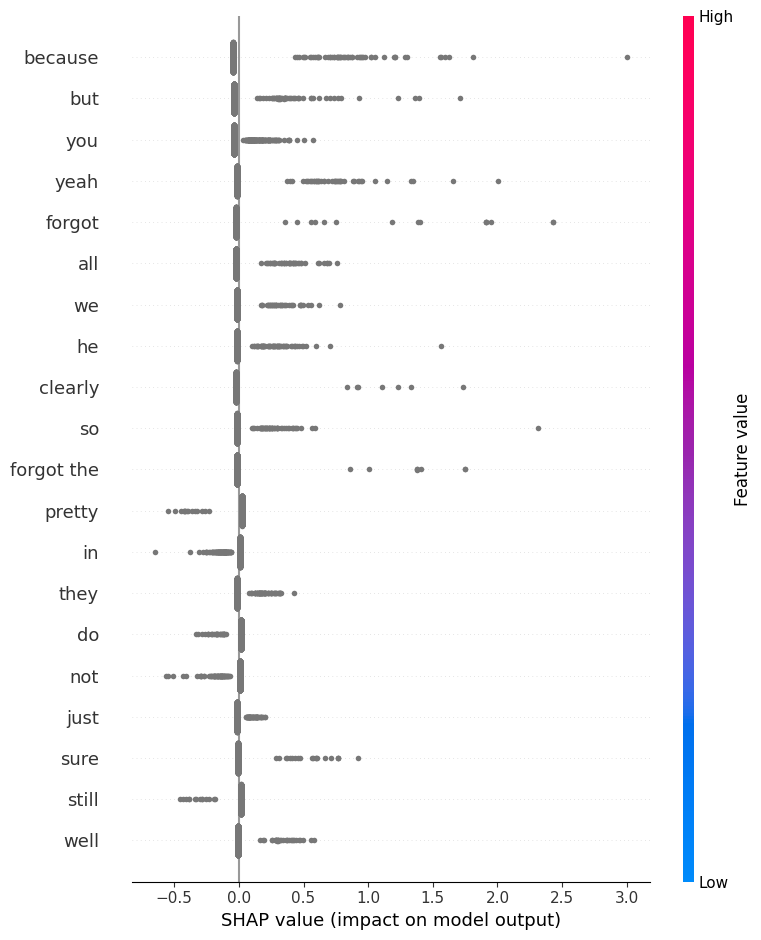

In [72]:
import shap

lr_X_train_transformed = lr.named_steps['tfidf'].transform(X_train)
lr_explainer = shap.LinearExplainer(lr.named_steps['clf'], lr_X_train_transformed[:1000])
lr_X_test_transformed = lr.named_steps['tfidf'].transform(X_test)
sample_size = 1000  # Choose a smaller sample size
lr_shap_values = lr_explainer.shap_values(lr_X_test_transformed[:1000])
shap.summary_plot(lr_shap_values, lr_X_test_transformed[:1000], feature_names=lr.named_steps['tfidf'].get_feature_names_out())